In [11]:
# Imports
import torch
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from string import punctuation
import re
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
# Set up GPU
# from torch import cuda
device = 'cpu'

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
file_path = '/content/drive/My Drive/UofT/IMDB_Dataset.csv'

df = pd.read_csv(file_path)
df = df.sample(frac=1.0, random_state=413)

df.rename(columns={'sentiment': 'labels'}, inplace=True)
label_mapping = {'positive': 1, 'negative': 0}
df['labels'] = df['labels'].map(label_mapping)
df.head()

,review,labels
21315,"First of all, it is interesting to note that o...",1
20835,The unthinkable has happened. Having first wit...,0
29274,One of the best records of Israel's response t...,1
32234,"But, lets face it... it got a few nostalgic si...",0
26597,Ben a out-of-town cop is convinced his sister ...,0


In [14]:
def clean_data(text):
    english_stopwords = set(stopwords.words("english"))
    cleaned_text = []
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(f'[{re.escape(punctuation)}]', ' ', text)
    for token in text.split():
        if token.lower() not in english_stopwords and not token.isdigit():
            cleaned_text.append(token.lower())
    return ' '.join(cleaned_text)

df['review'] = df['review'].apply(lambda x: clean_data(x))
df.head()

,review,labels
21315,first interesting note one users commented fil...,1
20835,unthinkable happened first witnessed years ago...,0
29274,one best records israel response murder rabin ...,1
32234,lets face got nostalgic sighs show consistentl...,0
26597,ben town cop convinced sister brutally killed ...,0


In [15]:
# Split dataset into 70% training, 10% validation, 20% testing
train_data = [[review, label] for review, label in zip(df.review[:35000], df.labels[:35000])]
val_data = [[review, label] for review, label in zip(df.review[35000:40000], df.labels[35000:40000])]
test_data = [[review, label] for review, label in zip(df.review[40000:], df.labels[40000:])]

In [16]:
import torchtext

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
train_data_words = [tokenizer(x) for x, t in train_data]

vocab = build_vocab_from_iterator(train_data_words,
                                  specials=['<bos>', '<eos>', '<unk>', '<pad>'],
                                  min_freq=10)

vocab.set_default_index(2)

In [17]:
def collate_batch(batch):
    text_list = []
    label_list = []
    for (text_indices, label) in batch:
        text_list.append(torch.tensor(text_indices))
        label_list.append(label)

    X = pad_sequence(text_list, padding_value=3).transpose(0, 1)
    t = torch.tensor(label_list)
    return X, t

In [26]:
def accuracy(model, dataset):
    correct, total = 0, 0
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            collate_fn=collate_batch)
    outputs, targets = [], []
    for i, (x, t) in enumerate(dataloader):
        x = x.to(device)
        t = t.to(device)
        z = model(x)
        y = torch.argmax(z, axis=1)
        outputs.append(y)
        targets.append(t)
        correct += int(torch.sum(t == y))
        total += 1
    precision, recall, f1, _ = precision_recall_fscore_support(targets, outputs, average="macro")
    return correct / total, precision, recall, f1

In [19]:
def train_model(model,                
                train_data,           
                val_data,             
                learning_rate=0.001,
                batch_size=100,
                num_epochs=10,
                plot_every=50,        
                plot=True):           
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate_batch,
                                               shuffle=True) 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0

    try:
        for e in range(num_epochs):
            for i, (texts, labels) in enumerate(train_loader):
                texts = texts.to(device)
                labels = labels.to(device)
                z = model(texts)

                loss = criterion(z, labels)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    ta, train_precision, train_recall, train_f1 = accuracy(model, train_data)
                    va, val_precision, val_recall, val_f1 = accuracy(model, val_data)
                    train_loss.append(float(loss))
                    train_acc.append(ta)
                    val_acc.append(va)
                    print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)
                    print(iter_count, "Train Precision:", train_precision, "Val Precision:", val_precision, "Train Recall:", train_recall, "Val Recall:", val_recall, "Train f1:", train_f1, "Val f1:", val_f1)
    finally:
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)], train_loss)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend(["Train", "Validation"])

In [20]:
from torchtext.vocab import GloVe
glove = torchtext.vocab.GloVe(name="6B", dim=300)

In [21]:
def convert_indices_glove(data, default=len(glove)-1):
    result = []
    for text, label in data:
        words = tokenizer(text)
        if len(words) > 1024:
          words = words[:1024]
        indices = []
        for w in words:
            if w in glove.stoi:
                indices.append(glove.stoi[w])
            else:
                indices.append(default)
        result.append((indices, label),)
    return result

train_data_glove = convert_indices_glove(train_data)
val_data_glove = convert_indices_glove(val_data)
test_data_glove = convert_indices_glove(test_data)

In [22]:
from torch import nn
class MyGloveLSTM(nn.Module):
    def __init__(self,  hidden_size, num_classes):
        super(MyGloveLSTM, self).__init__()
        self.vocab_size, self.emb_size = glove.vectors.shape
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.lstm = nn.LSTM(self.emb_size, hidden_size, num_layers=3, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, X):
        embedded = self.emb(X)
        output, hn = self.lstm(embedded)
        out = self.fc(torch.mean(output, dim=1))
        return out

    def parameters(self):
        for name, param in super().named_parameters(recurse=True):
          if name != 'emb.weight':
            yield param

50 Loss: 0.6883558630943298 Train Acc: 0.7035428571428571 Val Acc: 0.7182
50 Train Precision: 0.7091614095369875 Val Precision: 0.724537290805955 Train Recall: 0.7034534169687625 Val Recall: 0.717927671579357 Train f1: 0.7014792624837869 Val f1: 0.7160308276449814
100 Loss: 0.5987483859062195 Train Acc: 0.7572285714285715 Val Acc: 0.7628
100 Train Precision: 0.7648678870094807 Val Precision: 0.7706797033939967 Train Recall: 0.7571361235139284 Val Recall: 0.7625249282552653 Train f1: 0.7554208658847432 Val f1: 0.7609317871062491
150 Loss: 0.4023011028766632 Train Acc: 0.8039142857142857 Val Acc: 0.8028
150 Train Precision: 0.8109547133810798 Val Precision: 0.808939031209647 Train Recall: 0.8039958554857268 Val Recall: 0.8030245429713201 Train f1: 0.8028270497620897 Val f1: 0.8018947063533051
200 Loss: 0.37727364897727966 Train Acc: 0.8346857142857143 Val Acc: 0.834
200 Train Precision: 0.8346975873656195 Val Precision: 0.8339982950356353 Train Recall: 0.8346889316659734 Val Recall: 0.83

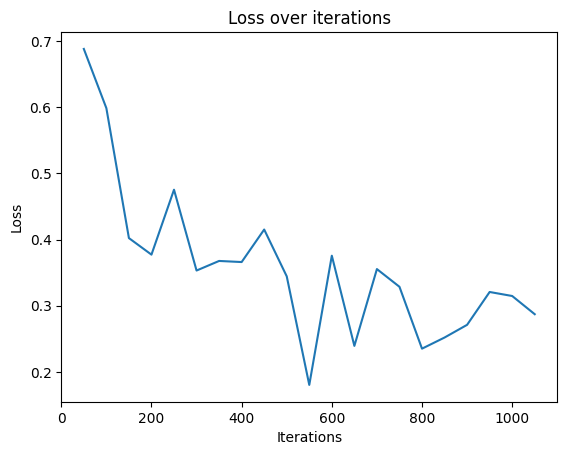

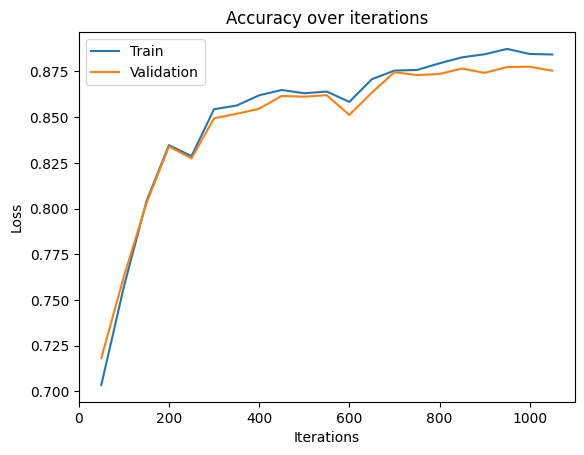

In [27]:
model = MyGloveLSTM(
              hidden_size=64,
              num_classes=2)
model = model.to(device)
train_model(model, train_data_glove, val_data_glove, num_epochs=3)

In [28]:
accuracy(model, test_data_glove)

(0.8746, 0.8748219965004567, 0.8746676253079539, 0.8745923701998028)